# Import Libraries

In [16]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import keras
from keras import Model
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

# 10.1 Load Base Model and Add New Layers



In [17]:
# 1. Load base model
base_model = MobileNet(weights='imagenet', include_top=False)


# 2. Add new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
preds = Dense(3, activation="softmax")(x)


# 3. Assign transfer base model + new layers to model
model = Model(inputs=base_model.input, outputs=preds)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                    

In [18]:
# 4. Assign Trainable layers and freeze layer 
for layer in model.layers[:40]:
  layer.trainable = False

for layer in model.layers[40:]:
  layer.trainable = True

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                    

### Compare layer tarinable

Before assign:
```
Total params: 5,854,403
Trainable params: 5,832,515
Non-trainable params: 21,888
```

Assign with layer: 20
```
Total params: 5,854,403
Trainable params: 5,818,499
Non-trainable params: 35,904
```

Assign with layer: 30
```
Total params: 5,854,403
Trainable params: 5,767,171
Non-trainable params: 87,232
```

Assign with layer: 40
```
Total params: 5,854,403
Trainable params: 5,695,491
Non-trainable params: 158,912
```

---

# 10.2 Model Training and Validation

## 10.2.1 Create ImageDataGenerator (Train, Validation)

In [39]:
# 1. Create DataGenerator Object
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=30,
                             zoom_range=0.5,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.15,
                             horizontal_flip=True,
                             fill_mode="nearest")


# 2. Create Train Image generator
train_generator = datagen.flow_from_directory('/content/drive/MyDrive/KMITL/ปี 3 เทอม 2/Image Processing/ship',
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              batch_size=64,
                                              class_mode='categorical',
                                              seed=1,
                                              shuffle=True)


# 3. Create Validation Image generator
val_generator = datagen.flow_from_directory('/content/drive/MyDrive/KMITL/ปี 3 เทอม 2/Image Processing/ship',
                                            target_size=(224, 224),
                                            color_mode='rgb',
                                            batch_size=64,
                                            class_mode='categorical',
                                            seed=1,
                                            shuffle=True)

Found 181 images belonging to 3 classes.
Found 181 images belonging to 3 classes.


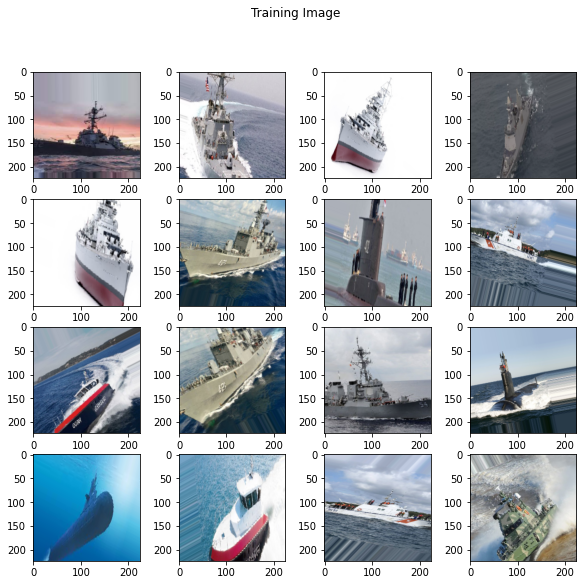

In [40]:
# View Training Images
fig = plt.figure(figsize=(10, 9))
fig.suptitle("Training Image")
rows = 4
columns = 4

for i in range(16):
  batch = train_generator.next()
  img_train = (batch[0])

  fig.add_subplot(rows, columns, i+1)
  plt.imshow(img_train[i])
plt.show()

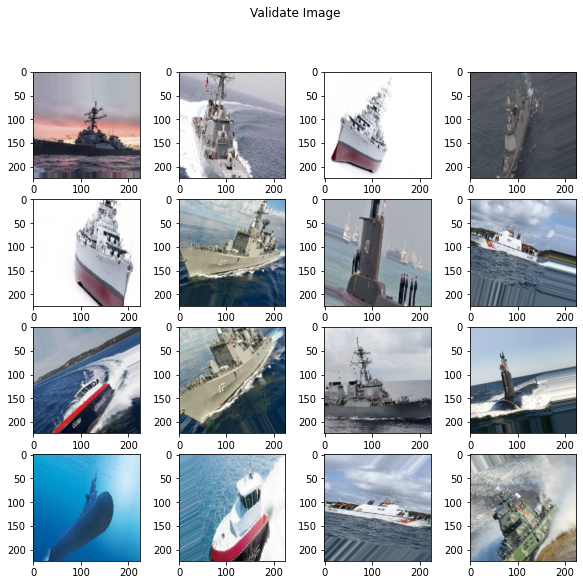

In [41]:
# View Validation Images
fig = plt.figure(figsize=(10, 9))
fig.suptitle("Validate Image")
rows = 4
columns = 4

for i in range(16):
  batch = val_generator.next()
  img_val = (batch[0])

  fig.add_subplot(rows, columns, i+1)
  plt.imshow(img_val[i])
plt.show()

## 10.2.2 Create Optimizer, parameters

In [42]:
# 4. Create Optimizer
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


# 5. Define training Generator Parameter
step_size_train = train_generator.n//train_generator.batch_size
step_size_val = val_generator.n//val_generator.batch_size

print("step_size_train:", step_size_train)
print("step_size_val:", step_size_val)

step_size_train: 2
step_size_val: 2


## 10.2.3 Training Validation, Plot accuracy, loss

In [43]:
# 6. Training
history = model.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    validation_data=val_generator,
                    validation_steps=step_size_val,
                    epochs=32,
                    verbose=1)

Epoch 1/32
2/2 [==============================] - 13s 8s/step - loss: 0.6595 - accuracy: 0.5128 - val_loss: 1.3947 - val_accuracy: 0.4688
Epoch 2/32
2/2 [==============================] - 8s 6s/step - loss: 0.7608 - accuracy: 0.5000 - val_loss: 1.5736 - val_accuracy: 0.5469
Epoch 3/32
2/2 [==============================] - 8s 6s/step - loss: 0.7047 - accuracy: 0.5812 - val_loss: 0.8948 - val_accuracy: 0.5547
Epoch 4/32
2/2 [==============================] - 8s 6s/step - loss: 0.6925 - accuracy: 0.6410 - val_loss: 1.1131 - val_accuracy: 0.5625
Epoch 5/32
2/2 [==============================] - 8s 7s/step - loss: 0.6644 - accuracy: 0.6838 - val_loss: 1.0120 - val_accuracy: 0.5703
Epoch 6/32
2/2 [==============================] - 8s 6s/step - loss: 0.6599 - accuracy: 0.5983 - val_loss: 1.0343 - val_accuracy: 0.6328
Epoch 7/32
2/2 [==============================] - 8s 6s/step - loss: 0.6751 - accuracy: 0.5812 - val_loss: 0.8312 - val_accuracy: 0.6094
Epoch 8/32
2/2 [========================

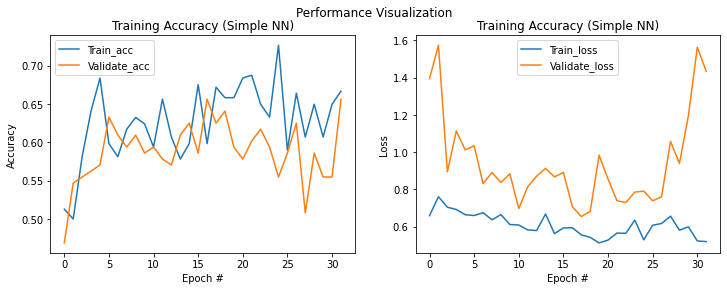

In [44]:
# 7. Performance Visualization
fig = plt.figure(figsize=(12, 4))
fig.suptitle("Performance Visualization")
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.plot(history.history["accuracy"], label='Train_acc')
plt.plot(history.history["val_accuracy"], label='Validate_acc')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.title("Training Accuracy (Simple NN)")
plt.legend()

fig.add_subplot(rows, columns, 2)
plt.plot(history.history["loss"], label='Train_loss')
plt.plot(history.history["val_loss"], label='Validate_loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.title("Training Accuracy (Simple NN)")
plt.legend()

plt.show()

---

# 10.3 Model Testing and Performance Visualize

## 10.3.1 Create ImageDataGenerator (Test) and Predict Results

In [45]:
# 1. Initial test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/KMITL/ปี 3 เทอม 2/Image Processing/ship',
                                                  class_mode="categorical",
                                                  target_size=(224, 224),
                                                  color_mode='rgb',
                                                  shuffle="False",
                                                  seed=42,
                                                  batch_size=1)


# 2. Get class id for y_real_class
y_true = test_generator.classes


# 3. Predict 1 image at a time for total predict images = len(y_true) # number of real class
test_generator.reset()
pred_prob = []
for i in range(len(y_true)):
  img_test = test_generator.next()
  pred = model.predict(img_test[0], verbose=0)
  pred_prob.append(np.array(pred[0]))

Found 181 images belonging to 3 classes.


In [46]:
# 4. Get class id from max prob
df_pred = pd.DataFrame(pred_prob)
df_class = df_pred.idxmax(axis=1)

# 5. Calculate confusion matrix, classfication report between y_true and df_class
print("Confusion Matrix:")
print(confusion_matrix(y_true, df_class))
print("-------------------------------------------")
print("Classification Report:")
print(classification_report(y_true, df_class))

Confusion Matrix:
[[ 0 15  0]
 [10 87  0]
 [ 8 61  0]]
-------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.53      0.90      0.67        97
           2       0.00      0.00      0.00        69

    accuracy                           0.48       181
   macro avg       0.18      0.30      0.22       181
weighted avg       0.29      0.48      0.36       181



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---

# Question

### Q1: Number of training, validationm, test images?
- จำนวนข้อมูลในแต่ละ class ที่สร้างจาก ImageDataGenerator มีปริมาณ ไม่ใกล้เคียงกัน
- จำนวนข้อมูลทั้งหมดมีมากพอให้เข้าใจความแตกต่างของ class

### Q2: Which pretrain layers are set trainable
- ปรับแล้ว accuracy เพิ่มขึ้น เช่น 20 กับ 40 accuracy ของ 40 มากกว่า

### Q3: What is the maximum accuracies of train, validation, test(predict) ?
- train = 0.6644, validation = 0.6500, test(predict) = 0.55

### Q4: เมื่อ training ผ่านไปในแต่ละ Epoch
- Training accuracy กับ Validation accuracy เมื่อผ่านไปประมาณ 50 epoch เริ่มแกว่งน้อยลง มากกว่า 55%
- Training Loss กับ Validation Loss เมื่อผ่านไปประมาณ 50 epoch เริ่มแกว่งน้อยลง ต่ำกว่า 0.75
- เพิ่มจำนวน Epoch แล้วค่า accuracy เพิ่มขึ้น, loss น้อยลง
  - 2 epoch = 0.32
  - 4 epoch = 0.14
  - 8 epoch = 0.41
  - 16 epoch = 0.49
  - 32 epoch = 0.54

### Q5: จาก confusion matrix ดูอย่างไรว่า class ไหน ทำนายผิดและที่ทำนายผิด ทำนายไปเป็น class ใด
- ดูจาก matrix ว่าใน row ของ class นั้นทายเป็น class อะไร
- support คือ จำนวนข้อมูลใน class  

#### ตัวอย่างการดู confusion matrix
- class1 ในตำแหน่ง 0,0 เป็น 0 ซึ่งต้องทายว่าเป็น 16 จึงจะ accuracy 100%
- แต่ใน ตย ไปทายตำแน่ง 0,1 แทน ซึ่งเป็น class2
- แสดงว่า class1 ทำนายผิดไปทายว่าเป็น class2

#### การดู precision
- class1 มีการทายทั้งหมด 4+45+7=56 ครั้ง 
- ซึ่งทายถูกว่าเป็น class1 = 4 ครั้ง
- แสดงว่าทายแม่น = 4/56 = 0.07

#### การดู recall
- class1 มีทั้งหมด 16
- ซึ่งทายถูกว่าเป็น class1 = 4 ครั้ง
- แสดงว่า recall = 4/16 = 0.25